In [310]:
# Imports
import contextily as cx 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Inverse distance weighted interpolation

### Read and prepare data

In [311]:
# Read data from .csv file, drop apartments without location data
df = pd.read_csv("data/20-04-23.csv")
df = df[df.longitude != 0.0]
df.head()

,id,rooms,area,rent,latitude,longitude
0,5248131,1,38,5216,55.652406,12.512200
1,5275700,1,37,7900,55.671065,12.501394
2,5211187,1,40,6300,55.649554,12.551497
3,5263181,3,73,11000,55.663465,12.542260
4,5249720,3,73,11000,55.663465,12.542260


In [312]:
# Add column for normalised rent = rent / area
df["norm_rent"] = round(df.rent / df.area, 2)
df.head()

,id,rooms,area,rent,latitude,longitude,norm_rent
0,5248131,1,38,5216,55.652406,12.512200,137.26
1,5275700,1,37,7900,55.671065,12.501394,213.51
2,5211187,1,40,6300,55.649554,12.551497,157.50
3,5263181,3,73,11000,55.663465,12.542260,150.68
4,5249720,3,73,11000,55.663465,12.542260,150.68


In [313]:
# Save dataframe with new column 'norm_rent' to .csv file
# df.to_csv('data/20-04-23_norm.csv', index=False)

In [314]:
# Create GeoDataFrame from Pandas DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf.head()

,id,rooms,area,rent,latitude,longitude,norm_rent,geometry
0,5248131,1,38,5216,55.652406,12.512200,137.26,POINT (12.51220 55.65241)
1,5275700,1,37,7900,55.671065,12.501394,213.51,POINT (12.50139 55.67106)
2,5211187,1,40,6300,55.649554,12.551497,157.50,POINT (12.55150 55.64955)
3,5263181,3,73,11000,55.663465,12.542260,150.68,POINT (12.54226 55.66347)
4,5249720,3,73,11000,55.663465,12.542260,150.68,POINT (12.54226 55.66347)


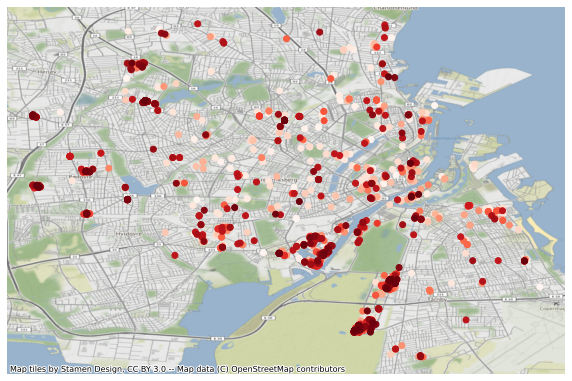

In [315]:
# Visualise 
ax = gdf.plot(c=gdf["norm_rent"], cmap='Reds', figsize=(10,10))
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

### Grid for interpolation

In [316]:
# Borders of the grid for interpolation
lon_min, lat_min, lon_max, lat_max = gdf.geometry.total_bounds
print(f"lon: {lon_max}-{lon_min}={round(lon_max-lon_min, 6)}, lat: {lat_max}-{lat_min}={round(lat_max-lat_min, 6)}")

lon: 12.642434-12.433844=0.20859, lat: 55.743446-55.606455=0.136991


In [317]:
# Set step size for grid creation based on longitude 
# n - number of points on the same latitude
n = 10
step = (lon_max - lon_min) / n

In [318]:
# Create grid of points
grid = []
for lat in np.arange(lat_min, lat_max, step):
    for lon in np.arange(lon_min, lon_max, step):
        grid.append([round(lon,6), round(lat,6)])
print(f"Grid consists of {len(grid)} points")

Grid consists of 70 points


In [319]:
# Create grid DataFrame and GeoDataFrame 
grid_df = pd.DataFrame(grid, columns=['longitude', 'latitude'])
grid_gdf = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude), crs="EPSG:4326")
grid_gdf.head()

,longitude,latitude,geometry
0,12.433844,55.606455,POINT (12.43384 55.60645)
1,12.454703,55.606455,POINT (12.45470 55.60645)
2,12.475562,55.606455,POINT (12.47556 55.60645)
3,12.496421,55.606455,POINT (12.49642 55.60645)
4,12.517280,55.606455,POINT (12.51728 55.60645)


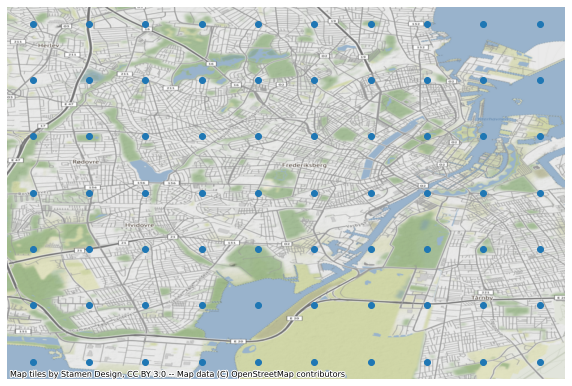

In [320]:
# Visualise grid
ax = grid_gdf.plot(figsize=(10, 10))
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

### Find nearest neighbors

In [321]:
# Put apartment coordinates into numpy array
apartments = np.array([[row.longitude, row.latitude] for index, row in df.iterrows()])

In [322]:
# Put grid point coordinates into numpy array
grid = np.array(grid)

In [323]:
# Fit apartment coordinates into nearest neighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(apartments)

In [324]:
# Find k nearest neighbors - k nearest apartments to grid points
distances, indices = nbrs.kneighbors(grid)

In [325]:
# Get unique set of neighbors
unique_indices = set(indices.flatten())
neighbors = gdf[gdf.index.isin(unique_indices)].copy()

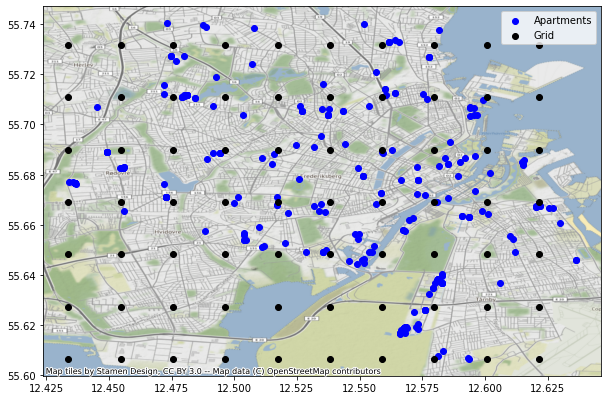

In [326]:
# Visualise grid points and its neighbors
fig, ax = plt.subplots(figsize=(10, 10))
neighbors.plot(ax=ax, color='blue')
grid_gdf.plot(ax=ax, color='black')
ax.legend(['Apartments', 'Grid'], loc='upper right')
cx.add_basemap(ax, crs=gdf.crs)
plt.show()

### Formula for IDW interpolation

$$
z_p = 
\frac{
        \sum_{i=1}^{n}
        \big( 
            \frac{z_i}{{d_i}^p}
        \big)
    }
    {
        \sum_{i=1}^{n}
        \big( 
            \frac{1}{{d_i}^p}
        \big)
    }
$$

$$
z_p - \text{interpolated value with a given power p} \\
z_i - \text{value at known point i} \\
d_i - \text{distance to the known point i} \\
p - \text{power}
$$
source:
https://gisgeography.com/inverse-distance-weighting-idw-interpolation/

In [327]:
# Interpolate value of normalised rent over grid of points
interpolated_norm_rent = []
for i, d in zip(indices, distances):
    norm_rent = [df.iloc[_].norm_rent for _ in i]
    numerator = norm_rent / d
    denominator = 1 / d
    interpolated_norm_rent.append(sum(numerator) / sum(denominator))
interpolated_norm_rent

[210.72553783942615,
 194.10432813274002,
 132.94416823457792,
 191.4903495478367,
 207.40051491035817,
 186.26175848638604,
 166.41089818302143,
 150.05763153057748,
 109.57186508702345,
 153.7073354945603,
 210.6512839027747,
 227.262,
 131.15718441215216,
 130.80525644398057,
 226.24600000000004,
 153.524,
 159.52258218278683,
 140.538,
 143.63864712894835,
 185.92306606155086,
 178.9881991787764,
 227.26199999999994,
 132.7542712063815,
 122.59869801089906,
 167.27742910805898,
 169.5336625604786,
 171.0458219069398,
 145.8796150181548,
 170.195404271822,
 176.98263623714908,
 140.72081263963685,
 170.86550374304343,
 150.036,
 212.35350990020228,
 207.59436336640528,
 219.47018327312801,
 157.04596768222643,
 143.20035760500744,
 164.19396668317188,
 181.677981703245,
 141.30575783711814,
 145.502,
 151.48282238703916,
 251.47800000000004,
 182.83121635026853,
 270.2361980051341,
 149.97301949686104,
 159.7547062952433,
 175.59070830034156,
 133.7696658961681,
 123.5905842262389,


In [328]:
# Add interpolated values as a new column of the existing DataFrame
grid_gdf["interpolated_norm_rent"] = interpolated_norm_rent

In [329]:
grid_gdf.head()

,longitude,latitude,geometry,interpolated_norm_rent
0,12.433844,55.606455,POINT (12.43384 55.60645),210.725538
1,12.454703,55.606455,POINT (12.45470 55.60645),194.104328
2,12.475562,55.606455,POINT (12.47556 55.60645),132.944168
3,12.496421,55.606455,POINT (12.49642 55.60645),191.490350
4,12.517280,55.606455,POINT (12.51728 55.60645),207.400515


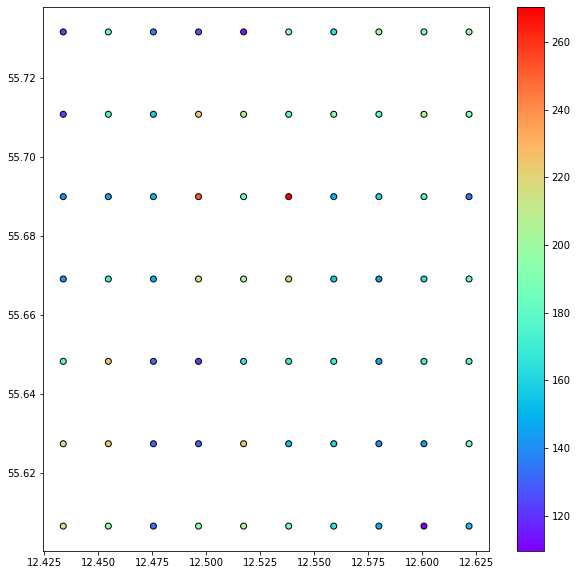

In [330]:
# Visualise values of interpolated norm_rent
fig, ax = plt.subplots(figsize=(10, 10))
# plt.imshow(grid, extent=(lon_min, lon_max, lat_min, lat_max), cmap='rainbow', interpolation='gaussian')
plt.scatter(grid_df.longitude, grid_df.latitude, c=grid_df.interpolated_norm_rent, cmap='rainbow', edgecolors='black')
plt.colorbar()

In [331]:
# Save interpolation
# grid_df.to_csv('data/simple_interpolation_2.csv', index=False)